In [1]:
%load_ext autoreload
%autoreload 2

import ray
ray.init(ignore_reinit_error=True)

2020-05-23 16:17:24,969	INFO resource_spec.py:212 -- Starting Ray with 35.16 GiB memory available for workers and up to 17.6 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-23 16:17:25,504	INFO services.py:1170 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '10.116.28.26',
 'raylet_ip_address': '10.116.28.26',
 'redis_address': '10.116.28.26:28881',
 'object_store_address': '/tmp/ray/session_2020-05-23_16-17-24_966239_27942/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-05-23_16-17-24_966239_27942/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-05-23_16-17-24_966239_27942'}

In [2]:
%config InlineBackend.figure_format = 'svg'
import mpltern
from matplotlib import rc
rc('text', usetex=True)
import seaborn as sns
import matplotlib.pyplot as plt

import pdb
import numpy as np

import sys
if '../' not in sys.path:
    sys.path.append('../')

from solvers.utils import makegrid3d, get_data

import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/projects/academic/olgawodo/kiranvad/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/projects/academic/olgawodo/kiranvad/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [45]:
from scipy.spatial import ConvexHull
import numpy as np
from math import pi

def get_ternary_coords(point):
    a,b,c = point
    x = 0.5-a*np.cos(pi/3)+b/2;
    y = 0.866-a*np.sin(pi/3)-b*(1/np.tan(pi/6)/2);
    
    return [x,y]

def flory_huggins(x, M,CHI,beta=1e-3):
    T1 = 0
    for i,xi in enumerate(x):
        T1 += (xi*np.log(xi))/M[i] + beta/xi
    T2 = 0.5*np.matmul((np.matmul(x,CHI)),np.transpose(x)) 
    
    return T1+T2  

def makegrid3d(num=50):
    X = np.linspace(0.001,0.999,num=num)
    Y,Z = X,X
    grid = []
    for x in X:
        for y in Y:
            for z in Z:
                if np.isclose(x+y+z,1.0,atol=1e-3,rtol=1e-3):
                    grid.append([x,y,z])
           
    return grid

@ray.remote(num_return_vals=4)
def setup_data(M,CHI,meshsize=40):
    grid = np.asarray(makegrid3d(num=meshsize))
    gmix = lambda x: flory_huggins(x, M, CHI,beta=1e-4)
    energy, coords = [],[]
    for point in grid:
        energy.append(gmix(point))
        coords.append(get_ternary_coords(point))

    points = np.concatenate((coords,np.asarray(energy).reshape(-1,1)),axis=1)
    hull = ConvexHull(points)
    coords = np.asarray(coords)

    return grid, energy, hull,coords

@ray.remote(num_return_vals=2)
def refine_and_label_simplices(hull,grid,coords):
    simplices, num_comp_list = [],[]
    for simplex in hull.simplices:
        point_class = np.sum(np.isclose(grid[simplex],0.001),axis=1)
        point_class = np.unique(3 - point_class)
        if (point_class==1).any():
            pass
        else:
            simplices.append(simplex)
            num_comp_list.append(label_simplex(simplex,thresh,coords))
    
    return simplices, num_comp_list

from scipy.spatial.distance import pdist, euclidean, squareform
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

def label_simplex(simplex,thresh,coords):
    tri_coords = coords[simplex,:]
    dist = squareform(pdist(tri_coords,'euclidean'))
    adjacency = dist<thresh
    adjacency =  adjacency.astype(int)  
    graph = csr_matrix(adjacency)
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)

    return n_components

def plot_phase_diagram(simplices,num_comps,coords,info):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    poly_coords = np.array([[0.0,0.0],[1.0,0.0],[0.5,np.sqrt(3)/2+0.01]])
    ax.add_patch(plt.Polygon(poly_coords,edgecolor=None, facecolor='brown',fill=True))
    words = [r'$\varphi_{p1}$',r'$\varphi_{p2}$',r'$\varphi_{s}$']
    xs = [-0.15,1,0.5]
    ys = [0,0,np.sqrt(3)/2+0.01]
    for x, y, s in zip(xs,ys,words):
        plt.text(x,y,s,fontsize=20)
    for i, triangle in zip(num_comps,simplices):
        tri_coords = coords[triangle,:]
        if i==2:
            ax.add_patch(plt.Polygon(tri_coords, edgecolor=None,facecolor='orange',fill=True))
        elif i==3:
            ax.add_patch(plt.Polygon(tri_coords,edgecolor=None, facecolor='lightblue',fill=True))

    ax.set_title(info['params'],pad=20)
    plt.axis('off')
    plt.legend(['1-phase','2-phase','3-phase'])
    #plt.savefig('../figures/May13Wed/'+info['fname']+'.png',dpi=500,bbox_inches='tight')
    plt.show()

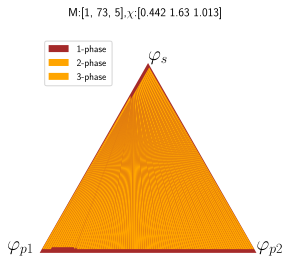

Total elapsed time is: 42.12388825416565


In [49]:
import time
since = time.time()
M,CHI,info=get_data(name='FHPaper',fhid=4)
grid, energy, hull,coords = setup_data.remote(M,CHI,meshsize=200)
thresh = 5*euclidean(ray.get(coords)[0,:],ray.get(coords)[1,:])
simplices,num_comps  = ray.get(refine_and_label_simplices.remote(hull,grid,coords))
plot_phase_diagram(simplices,num_comps,ray.get(coords),info)
print('Total elapsed time is: {}'.format(time.time()-since))